In [2]:
%load_ext autoreload
%autoreload
from tune_and_draw import TuneAndDraw
from fedhybrid_innerloops import FedHybrid
from parameter import TuneParam,TrainParam
from costFunc import LogisticCostFunc
import numpy as np
import random
from sklearn.datasets import load_boston
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from datetime import datetime
import json
import pandas as pd
import numpy as np
import random
from scipy.optimize import minimize

In [3]:
def dataset(nclient): 
    np.random.seed(2022)
    random.seed(2022)
    df =  pd.read_table('agaricus-lepiota.data', delimiter=',', header=None)
    column_labels = [
            'class', 'cap shape', 'cap surface', 'cap color', 'bruised', 'odor',
            'gill attachment', 'gill spacing', 'gill size', 'gill color', 
            'stalk shape', 'stalk root', 'stalk surface above ring',
            'stalk surface below ring', 'stalk color above ring',
            'stalk color below ring', 'veil type', 'veil color', 'ring number',
            'ring type', 'spore print color', 'population', 'habitat']

    df.columns = column_labels
    
        # excluding any training example that has missing values for stalk root.
    df = df[df['stalk root'] != '?']

    X = df.loc[:, df.columns != 'class']
    y = df['class'].to_frame()

    # Encoding categorical features
    X_enc = pd.get_dummies(X)
    # Standardizing the features
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X_enc)

    # Encoding the target variable
    le = LabelEncoder()
    y_enc = le.fit_transform(y.values.ravel())

    X_train, X_test, y_train, y_test = train_test_split(X_std, y_enc, test_size=0.3, stratify=y_enc, random_state=42)

    # number of examples
    #n=354# same as quadratic housing
    n = X_train.shape[0]
    # ndim
    ndim = X_train.shape[1] + 1
    # number of classes
    k = 2
    label = [0,1]

    intercept = np.ones((X_train.shape[0], 1))
    X_train = np.hstack((intercept, X_train))
    intercept = np.ones((X_test.shape[0], 1))
    X_test = np.hstack((intercept, X_test))

    # Not uniformly distributed among clients

    X_train, y_train = shuffle(X_train, y_train)    

    X_df = pd.DataFrame([y_train, X_train])

    X_df = X_df.T
    X_df.columns = ['y_train', 'X_train']

    X_df = X_df.reset_index()
    #print(X_df.columns)
    #X_df=X_df.iloc[:354]

    # Split it into different groups according to the label
    X_df_0 = X_df[X_df['y_train']==0]
    X_df_1 = X_df[X_df['y_train']==1]
    #print('len(X_df_0),len(X_df_1)',len(X_df_0),len(X_df_1))
    #ni=[45, 38, 29, 12, 62, 76, 36, 56]#same as quadratic housing
    p = np.zeros(nclient)
    s = 0
    for i in range(nclient):
        p[i] = np.random.lognormal(4, 2) + 50
        s += p[i]
    p = p/s
    ni = p * n
    ni = [int(num) for num in ni]
    ni[-1] = ni[-1] + n - sum(ni) 
    X_df_reorder = pd.concat([X_df_0, X_df_1])
    indices_set = [[] for i in range(nclient)]
    s = 0
    for j in range(nclient):
        indices_set[j] =  X_df_reorder['index'].to_list()[s:s+ni[j]]
        s += ni[j]
    A = [[] for _ in range(nclient)]
    y = [[] for _ in range(nclient)]
    for i in range(nclient):
        A[i] = X_train[indices_set[i]]
        y[i] = y_train[indices_set[i]]

    for i in range(nclient):
        print(ni[i])
    return A,y

In [4]:
def prepare(nclient):
    A,y =dataset(nclient)
    gamma = 1
    func = LogisticCostFunc(A, y, gamma)

    initial_x =np.zeros([func.ndim,1])
    fn_min = minimize(func.global_func, initial_x, tol=1e-30) #result object
    fn_star = fn_min.fun
    method = FedHybrid(func, fn_star)
    tuneAndDraw = TuneAndDraw(nclient, initial_x,setup=4)
    return method,tuneAndDraw

synchronous logistic mushroom

273
239
317
237
228
221
2154
281
data int64
2.016127931270262e-09 279 1
1.9154934860488027e-09 203 1
1.943076144428346e-09 196 1
1.887490774787892e-09 146 1
1.968873092339507e-09 44 1


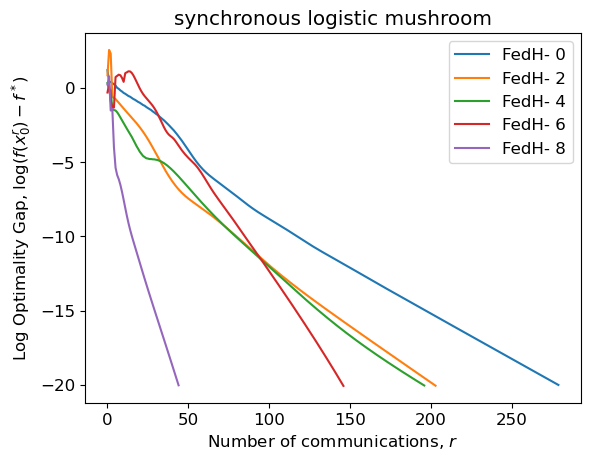

In [5]:
method,tuneAndDraw = prepare(8)
ns=[0,2,4,6,8]
innerIterations = 1
df = tuneAndDraw.readPa(ns,innerIterations)
filename="./analyze data/analyze data/sync_and_async/4 synchronous logistic mushroom.pdf"
tuneAndDraw.draw(df,method.train_innerloop_lambdaBefore,"synchronous logistic mushroom",filename,save = 1,asyn=0,possionBeta=[])

innerloop 4 logistic mushroom

273
239
317
237
228
221
2154
281
data int64
1.74617179049541e-09 93 1
2.023854861477048e-09 104 1
1.8435671877981008e-09 89 1
1.9617404645178027e-09 77 1
1.968873092339507e-09 44 1


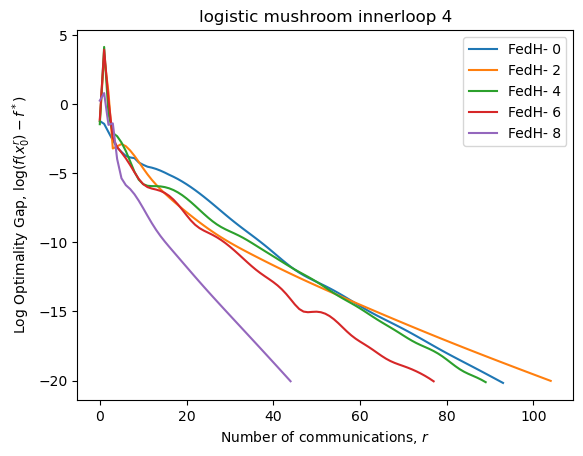

In [5]:
method,tuneAndDraw = prepare(8)
ns=[0,2,4,6,8]
innerIterations = 4
df = tuneAndDraw.readPa(ns,innerIterations)
filename="./analyze data/analyze data/sync_and_async/4 innerloop 4 logistic mushroom 2.pdf"
tuneAndDraw.draw(df,method.train_innerloop_lambdaBefore,"logistic mushroom innerloop 4",filename,save = 1,asyn=0,possionBeta=[])

async logistic mushroom

273
239
317
237
228
221
2154
281
data int64
2.0574733583522686e-09 14460 1
1.9373692650148655e-09 12450 1
1.930899690139043e-09 29735 1
2.0603127537377475e-09 30043 1
2.0138646583678366e-09 20576 1


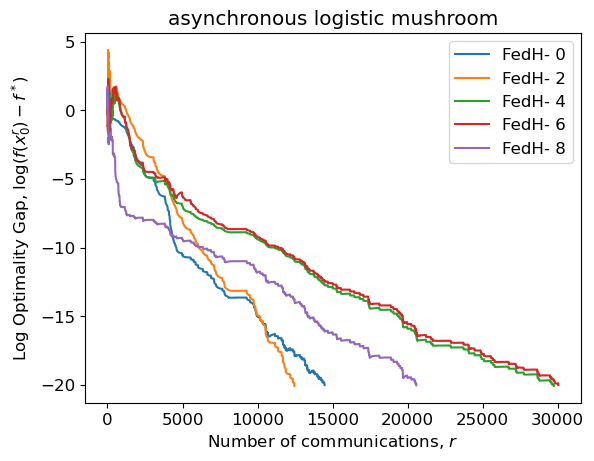

In [16]:
method,tuneAndDraw = prepare(8)
ns=[0,2,4,6,8]
innerIterations = 0
df = tuneAndDraw.readPa(ns,innerIterations)
filename="./analyze data/analyze data/sync_and_async/4 asynchronous logistic mushroom.pdf"
tuneAndDraw.draw(df,method.asynchronousTrain2,"asynchronous logistic mushroom",filename,save = 1,asyn=1,possionBeta=[5, 10, 4, 1, 2, 7, 100, 5])

In [4]:
nodes = [5,20,8]
for nclient in nodes:
    method,tuneAndDraw = prepare(nclient)
    if nclient ==15:
        ns=[0,3,6,9,12,15]
    elif nclient == 20:
        ns =[0,3,6,9,12,16,18,20]
    elif nclient ==5:
        ns =[0,1,2,3,4,5]
    elif nclient ==8:
        ns =[0,2,4,6,8]
    inner=[1,2,3,4]
    setup=4
    now = datetime.now() # current date and time
    date_time = now.strftime("%m_%d_%Y, %H_%M")# month date year
    Best_pa_bef = tuneAndDraw.tune(method,ns,inner,method.train_innerloop_lambdaBefore,'before')
    #Best_pa_after_new.to_csv('./setup_'+str(setup)+'_result/nodes/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_afterNew'+'.csv',index=False)
    #Best_pa_inner.to_csv('./setup_'+str(setup)+'_result/nodes/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_inner'+'.csv',index=False)
    #Best_pa_gra.to_csv('./setup_'+str(setup)+'_result/nodes/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_gradient'+'.csv',index=False)
    Best_pa_bef.to_csv('./setup_'+str(setup)+'_result/nodes/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_before'+'.csv',index=False)


833
728
969
722
698
5
5   0 :  [3, 2, 1, 0, -1, -2, -3] [-5, -6, -7, -8, -9, -10, -11] [0] [0] [-8, -7, -6, -5, -4, -3] 300 []
client_gradient [0 1 2 3 4]
client_newton []
<bound method FedHybrid.train_innerloop_lambdaBefore of <fedhybrid_innerloops.FedHybrid object at 0x7efd5066c8b0>> nclient 5
a_range [3, 2, 1, 0, -1, -2, -3] b_range [-5, -6, -7, -8, -9, -10, -11] a2_range [0] b2_range [0] mu_range [-8, -7, -6, -5, -4, -3] newton_client []
5
5   1 :  [3, 2, 1, 0, -1, -2, -3] [-5, -6, -7, -8, -9, -10, -11] [0] [-1, -2, -3, -4, -5, -6, -7] [-8, -7, -6, -5, -4, -3] 300 [0]
client_gradient [1 2 3 4]
client_newton [0]
<bound method FedHybrid.train_innerloop_lambdaBefore of <fedhybrid_innerloops.FedHybrid object at 0x7efd5066c8b0>> nclient 5
a_range [3, 2, 1, 0, -1, -2, -3] b_range [-5, -6, -7, -8, -9, -10, -11] a2_range [0] b2_range [-1, -2, -3, -4, -5, -6, -7] mu_range [-8, -7, -6, -5, -4, -3] newton_client [0]


In [ ]:
#old
333
gamma = 1
func = LogisticCostFunc(A, y, gamma)
initial_x =np.zeros([ndim,1])
fn_min = minimize(func.global_func, initial_x, tol=1e-30) #result object
fn_star = fn_min.fun 
method = FedHybrid(func, fn_star)
print(nclient)
tuneAndDraw = TuneAndDraw(nclient, initial_x,setup=4)
ns=[0,2,4,6,8]
inner=[1,2,3,4];
#tuneAndDraw.tune(method,ns,inner,method.train_innerloop,'inner')
BestPa_afterNew = tuneAndDraw.tune(method,ns,inner,method.train_innerloop_lambdaAfter)
BestPa_grad = tuneAndDraw.tune(method,ns,inner,method.train_innerloop_gradient_only)
BestPa_before = tuneAndDraw.tune(method,ns,inner,method.train_innerloop_lambdaBefore)

8
./setup_4_result/train/tune_newton_agent_setup4.csv
0 :  [3, 2, 1, 0, -1, -2, -3] [-2, -3, -4, -5, -6, -7, -8, -9] [0] [0] [-8, -7, -6, -5, -4, -3, -2, -1] 300 []
<bound method FedHybrid.train_innerloop_lambdaAfter of <fedhybrid_innerloops.FedHybrid object at 0x7f8cd45253a0>> nclient 8
a_range [3, 2, 1, 0, -1, -2, -3] b_range [-2, -3, -4, -5, -6, -7, -8, -9] a2_range [0] b2_range [0] mu_range [-8, -7, -6, -5, -4, -3, -2, -1] newton_client []
./setup_4_result/train/tune_newton_agent_setup4.csv
2 :  [3, 2, 1, 0, -1, -2, -3] [-2, -3, -4, -5, -6, -7, -8, -9] [0] [-1, -2, -3, -4, -5, -6, -7] [-8, -7, -6, -5, -4, -3, -2, -1] 300 [0 6]
<bound method FedHybrid.train_innerloop_lambdaAfter of <fedhybrid_innerloops.FedHybrid object at 0x7f8cd45253a0>> nclient 8
a_range [3, 2, 1, 0, -1, -2, -3] b_range [-2, -3, -4, -5, -6, -7, -8, -9] a2_range [0] b2_range [-1, -2, -3, -4, -5, -6, -7] mu_range [-8, -7, -6, -5, -4, -3, -2, -1] newton_client [0 6]
./setup_4_result/train/tune_newton_agent_setup4.cs